In [35]:
# Imports
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_theme()

from utils import calculate_nutripoints

# Load the statistical libraries

In [2]:
# Data Imports

year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())
print(year_grocery.shape)

fast_food = pd.read_excel(
    "data/Fast_food.xlsx", sheet_name="Ward Data", header=[3], usecols="E,G")
display(fast_food.head())
print(fast_food.shape)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


(638, 202)


,2015 Ward code,Count of outlets
0,E05001767,10
1,E05001768,10
2,E05001769,22
3,E05001770,81
4,E05001771,5


(5832, 2)


In [3]:
# year_grocery=year_grocery.sort_values(by='representativeness_norm', ascending=False, ignore_index=True)
year_grocery = year_grocery.nlargest(
    int(0.8*len(year_grocery)), 'representativeness_norm')

In [4]:
#nutripoints=['nutri_energy','nutri_sugar', 'nutri_saturate', 'nutri_sodium', 'nutri_fibre', 'nutri_protein', 'nutri_fruit_veg']
year_grocery["nutripoints"]=year_grocery.apply(calculate_nutripoints, axis=1)
year_grocery["nutripoints"].describe()

count    510.000000
mean       9.237255
std        1.469929
min        0.500000
25%        8.500000
50%        9.000000
75%       10.000000
max       14.500000
Name: nutripoints, dtype: float64

In [5]:
print(year_grocery.isna().any())
display(year_grocery.head())
print(year_grocery.shape)

area_id             False
weight              False
weight_perc2.5      False
weight_perc25       False
weight_perc50       False
                    ...  
age_65+             False
avg_age             False
area_sq_km          False
people_per_sq_km    False
nutripoints         False
Length: 203, dtype: bool


,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints
570,E05011117,382.039628,40.0,175.0,300.0,500.0,1000.0,363.202381,0.465398,105.990925,...,11911.0,6099.0,5812.0,1558.0,9552.0,801.0,34.867937,1.35,8822.962963,8.5
565,E05011112,398.825948,40.0,180.0,320.0,500.0,1000.0,397.149657,0.492467,107.602664,...,16365.0,8103.0,8262.0,2997.0,12218.0,1150.0,33.235625,1.30,12588.461538,8.0
246,E05000336,397.066289,40.0,180.0,300.0,500.0,1000.0,414.783419,0.608474,122.609742,...,11959.0,5764.0,6195.0,2625.0,7194.0,2140.0,40.250941,3.32,3602.108434,10.0
438,E05000605,416.199096,40.5,182.0,325.0,500.0,1200.0,506.239533,0.700727,107.997869,...,13599.0,7196.0,6403.0,2630.0,9919.0,1050.0,34.684389,1.31,10380.916031,9.0
162,E05000252,374.792470,40.0,173.7,300.0,500.0,1000.0,354.119901,0.563867,99.371843,...,12013.0,5828.0,6185.0,1709.0,8813.0,1491.0,37.502289,0.89,13497.752809,8.5


(510, 203)


In [6]:
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb",
               "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]
year_grocery = year_grocery.loc[:,year_grocery.columns.isin(list(list_column))]
display(year_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5


In [7]:
len(set(year_grocery["area_id"].values))

510

In [8]:
len(set(fast_food["2015 Ward code"].values))

5832

In [9]:
len(set(fast_food["2015 Ward code"].values)
    & set(year_grocery["area_id"].values))

440

In [10]:
fastfood_grocery = pd.merge(
    left=year_grocery, right=fast_food, left_on='area_id', right_on="2015 Ward code")
fastfood_grocery = fastfood_grocery.drop("2015 Ward code", axis=1)
display(fastfood_grocery.head())
print(fastfood_grocery.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,Count of outlets
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,15
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,13
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,8
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,9.0,14
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,9.0,25


(440, 12)


In [13]:
# Comprehension of the data
fastfood_grocery_columns = fastfood_grocery.columns.values.tolist()
fastfood_grocery_columns

['area_id',
 'energy_fat',
 'energy_saturate',
 'energy_sugar',
 'energy_protein',
 'energy_carb',
 'energy_fibre',
 'energy_alcohol',
 'energy_tot',
 'h_nutrients_calories',
 'nutripoints',
 'Count of outlets']

In [14]:
fastfood_grocery.isnull().any()

area_id                 False
energy_fat              False
energy_saturate         False
energy_sugar            False
energy_protein          False
energy_carb             False
energy_fibre            False
energy_alcohol          False
energy_tot              False
h_nutrients_calories    False
nutripoints             False
Count of outlets        False
dtype: bool

In [15]:
fastfood_grocery.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,Count of outlets
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,80.653871,31.811113,40.031539,21.093016,71.787149,3.027993,1.679636,178.241665,1.573155,9.256818,14.397727
std,2.909051,1.388606,3.306468,0.855441,5.520788,0.117759,0.364883,7.281531,0.025258,1.365437,13.933081
min,67.111854,26.173163,30.149908,17.596480,52.921834,2.750710,0.715793,147.541243,1.465237,5.000000,1.000000
25%,78.989452,30.955484,37.927397,20.696160,68.159543,2.947692,1.433929,173.856481,1.556885,8.500000,7.000000
50%,80.448641,31.660923,39.643719,21.229909,71.872886,3.022663,1.660522,178.583441,1.573913,9.000000,11.000000
75%,82.164445,32.544245,42.018439,21.675982,75.687417,3.093645,1.873801,182.536718,1.590158,10.000000,18.000000
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.490972,197.674474,1.680088,14.500000,147.000000


Text(0.5, 0.98, 'boxplot for each column')

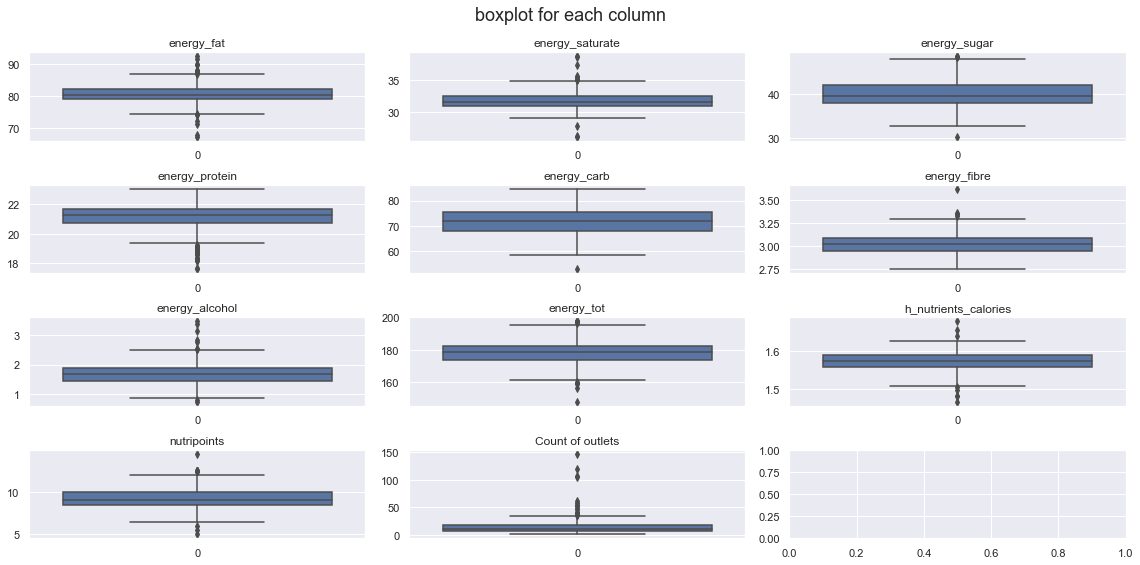

In [16]:
columns_grocery = [
    'energy_fat',
    'energy_saturate',
    'energy_sugar',
    'energy_protein',
    'energy_carb',
    'energy_fibre',
    'energy_alcohol',
    'energy_tot',
    'h_nutrients_calories', 
    'nutripoints',
    'Count of outlets'
]

column_boxplot = columns_grocery

fastfood_grocery_analysis = fastfood_grocery[column_boxplot].copy()
fig, ax = plt.subplots(4, 3, figsize=(16, 8), sharey=False)

for i in range(len(column_boxplot)):
    sbplt = ax[int(i/3), i % 3]

    sns.boxplot(data=fastfood_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(fastfood_grocery_analysis.columns[i], loc='center', wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('boxplot for each column', fontsize=18)

We observe that they are some outliers for the different variables. This is due to the differences between the different ward. 

Text(0.5, 0.98, 'histplot for each column')

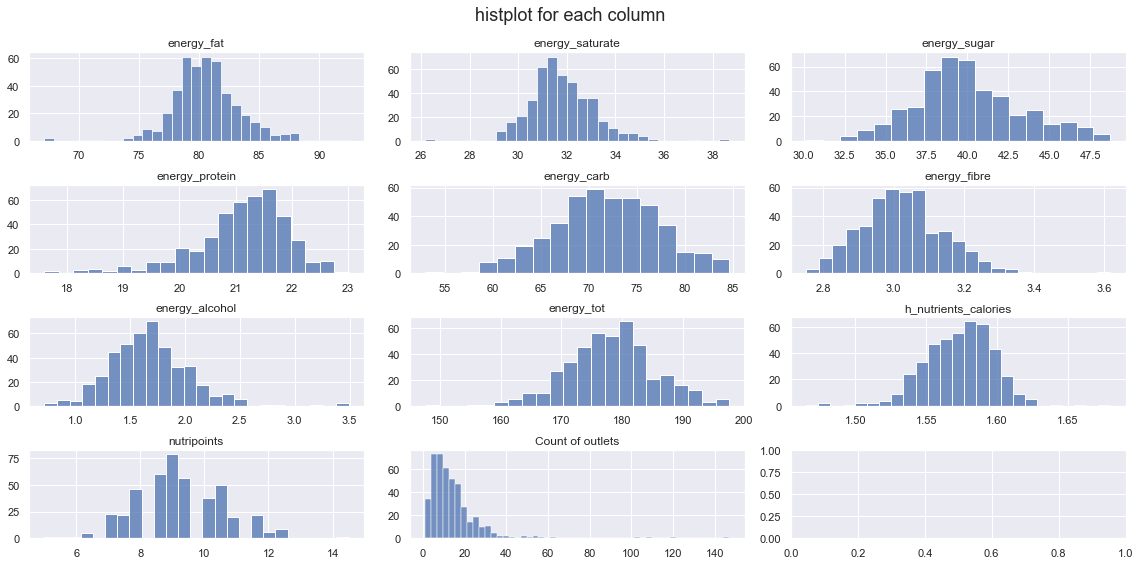

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(16, 8), sharey=False)

for i in range(len(column_boxplot)):
    sbplt = ax[int(i/3), i % 3]

    sns.histplot(data=fastfood_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(fastfood_grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('histplot for each column', fontsize=18)

<AxesSubplot:>

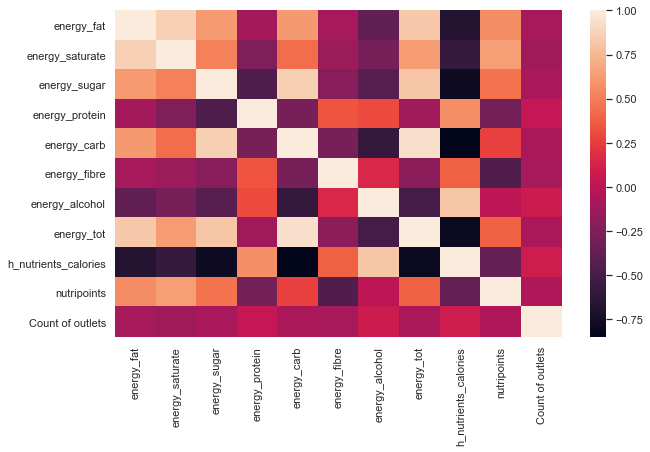

In [37]:
# correlations
fig = plt.figure(figsize=(10, 6))
sns.heatmap(fastfood_grocery_analysis.corr())

In [19]:
correlation = fastfood_grocery_analysis.corr(method="spearman")
display(correlation)

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,Count of outlets
energy_fat,1.000000,0.803704,0.572517,-0.075554,0.578959,-0.056916,-0.367048,0.789285,-0.614130,0.503449,-0.010292
energy_saturate,0.803704,1.000000,0.476986,-0.172232,0.384106,-0.071635,-0.218584,0.554786,-0.462356,0.598202,-0.105991
energy_sugar,0.572517,0.476986,1.000000,-0.492247,0.854858,-0.298361,-0.424235,0.804899,-0.786125,0.453315,-0.012535
energy_protein,-0.075554,-0.172232,-0.492247,1.000000,-0.304961,0.367520,0.285014,-0.150903,0.521516,-0.321298,0.052572
energy_carb,0.578959,0.384106,0.854858,-0.304961,1.000000,-0.354216,-0.595897,0.939228,-0.869891,0.267263,0.034797
energy_fibre,-0.056916,-0.071635,-0.298361,0.367520,-0.354216,1.000000,0.180452,-0.250381,0.411269,-0.455087,-0.213410
energy_alcohol,-0.367048,-0.218584,-0.424235,0.285014,-0.595897,0.180452,1.000000,-0.529745,0.812003,0.028423,0.000670
energy_tot,0.789285,0.554786,0.804899,-0.150903,0.939228,-0.250381,-0.529745,1.000000,-0.811788,0.349160,0.028182
h_nutrients_calories,-0.614130,-0.462356,-0.786125,0.521516,-0.869891,0.411269,0.812003,-0.811788,1.000000,-0.327422,-0.018201
nutripoints,0.503449,0.598202,0.453315,-0.321298,0.267263,-0.455087,0.028423,0.349160,-0.327422,1.000000,0.007811


energy_fat             -0.010292
energy_saturate        -0.105991
energy_sugar           -0.012535
energy_protein          0.052572
energy_carb             0.034797
energy_fibre           -0.213410
energy_alcohol          0.000670
energy_tot              0.028182
h_nutrients_calories   -0.018201
nutripoints             0.007811
Count of outlets        1.000000
Name: Count of outlets, dtype: float64

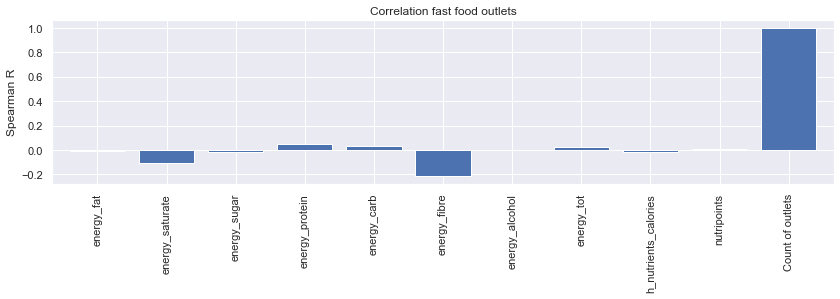

In [38]:
plt.figure(figsize=(14, 3))
display(correlation["Count of outlets"])
correlation["Count of outlets"].plot.bar(x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation fast food outlets")
plt.show()

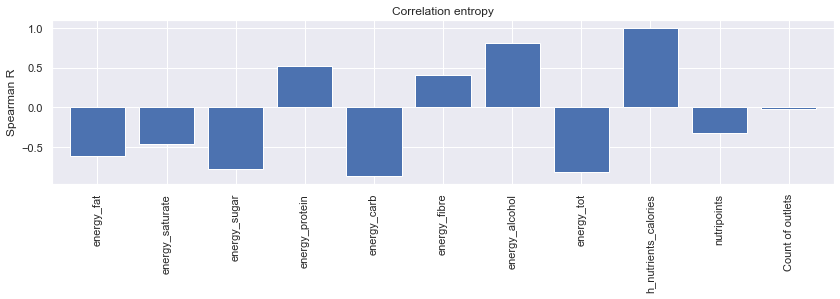

In [25]:
plt.figure(figsize=(14, 3))
correlation["h_nutrients_calories"].plot.bar(
    x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation entropy")
plt.show()

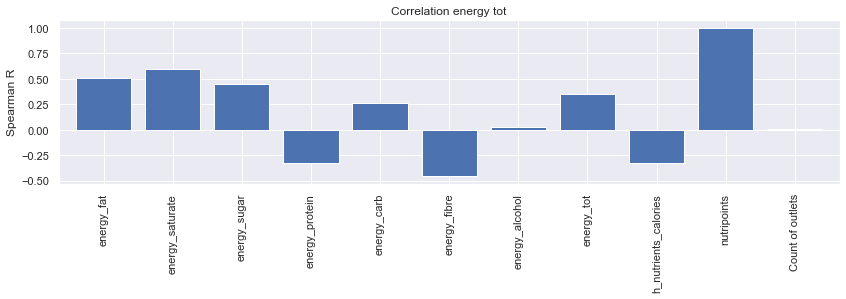

In [27]:
plt.figure(figsize=(14, 3))
correlation["nutripoints"].plot.bar(x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation energy tot")
plt.show()

In [28]:
scaler = StandardScaler()
fastfood_grocery_analysis[fastfood_grocery_analysis.columns] = scaler.fit_transform(fastfood_grocery_analysis
                                                                                      [fastfood_grocery_analysis.columns])
fastfood_grocery_analysis.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,Count of outlets
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,3.229740e-16,-1.735985e-15,1.291896e-16,1.065814e-15,-4.440892e-16,-2.083182e-15,-4.198662e-16,-2.115480e-15,-3.092476e-15,6.459479e-16,-5.652044e-17
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-4.660432e+00,-4.064772e+00,-2.991977e+00,-4.092060e+00,-3.421032e+00,-2.357331e+00,-2.644519e+00,-4.221003e+00,-4.277534e+00,-3.121099e+00,-9.626714e-01
25%,-5.728032e-01,-6.168797e-01,-6.370957e-01,-4.644476e-01,-6.578292e-01,-6.826793e-01,-6.741527e-01,-6.029193e-01,-6.448873e-01,-5.548990e-01,-5.315514e-01
50%,-7.062881e-02,-1.082820e-01,-1.174246e-01,1.602082e-01,1.554742e-02,-4.530949e-02,-5.244545e-02,4.699077e-02,3.007327e-02,-1.882991e-01,-2.441380e-01
75%,5.198583e-01,5.285635e-01,6.015973e-01,6.822562e-01,7.072736e-01,5.581446e-01,5.327337e-01,5.905271e-01,6.739627e-01,5.449009e-01,2.588353e-01
max,4.056427e+00,4.960090e+00,2.630447e+00,2.238609e+00,2.326903e+00,5.013161e+00,4.969802e+00,2.671818e+00,4.238500e+00,3.844301e+00,9.527915e+00


In [58]:
Y=fastfood_grocery[["nutripoints"]]
X=fastfood_grocery[["Count of outlets"]]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            nutripoints   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6930
Date:                Mon, 07 Dec 2020   Prob (F-statistic):              0.406
Time:                        12:26:54   Log-Likelihood:                -760.53
No. Observations:                 440   AIC:                             1525.
Df Residuals:                     438   BIC:                             1533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.3129      0.094  

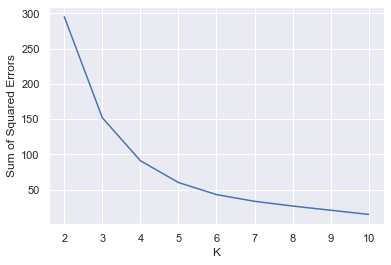

In [59]:
columns_kmeans = ['nutripoints']
fastfood_grocery_kmeans=fastfood_grocery[columns_kmeans].copy()

def plot_sse(X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        sse.append({"k": k, "sse": kmeans.inertia_})
    sse = pd.DataFrame(sse)
        # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(fastfood_grocery_kmeans)


Text(0, 0.5, 'Silhouette score')

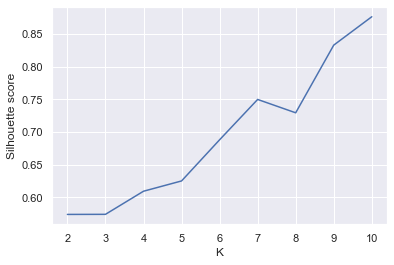

In [60]:
#######    silhouette scores to choose k    #########
silhouettes = []
for k in range(2, 11): # Try multiple k
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(fastfood_grocery_kmeans)
    # Get the Silhouette score
    score = silhouette_score(fastfood_grocery_kmeans, labels)
    silhouettes.append({"k": k, "score": score})
    
silhouettes = pd.DataFrame(silhouettes) # Convert to dataframe

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

<AxesSubplot:xlabel='nutripoints'>

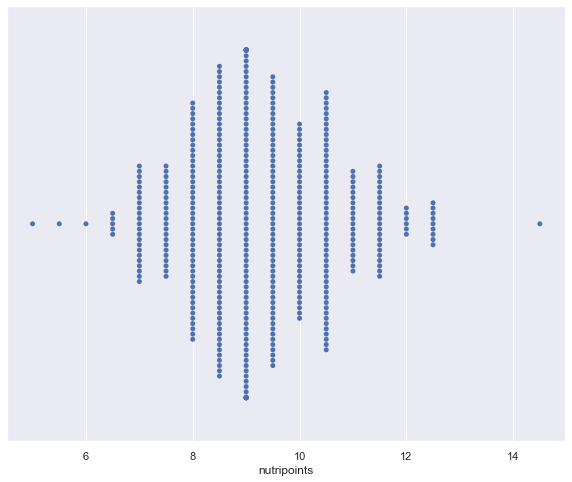

In [61]:
fig, axs = plt.subplots(1, 1, figsize=(10,8), sharey=True, sharex=True)

# Cluster the data with the current number of clusters
kmean = KMeans(n_clusters=4, random_state=42).fit(fastfood_grocery_kmeans)

# Plot the data by using the labels as color
#axs.scatter(wellbeing_grocery_kmeans, wellbeing_grocery_kmeans, c=kmean.labels_)
fastfood_grocery_kmeans['label']=kmean.labels_
sns.swarmplot(data=fastfood_grocery_kmeans, x='nutripoints', ax=axs, hue=fastfood_grocery_kmeans.label)
# Plot the centroids
#for c in kmean.cluster_centers_:
    #axs.scatter(c[0], c[1], marker="+", color="red")

In [62]:
fastfood_grocery["nutri_label"]=kmean.labels_
fastfood_grocery.groupby("nutri_label")["nutripoints"].min()

nutri_label
0    10.5
1     8.0
2     5.0
3     9.5
Name: nutripoints, dtype: float64

In [63]:
## linear regression ##
lin_reg = LinearRegression()  # create the model
lin_reg.fit(X,Y)  # train it

LinearRegression()

In [65]:
print("{0} * {1} + ".format(lin_reg.coef_[0], "Count of outlets"))
print(lin_reg.intercept_)

[ 0.         -0.00389498] * Count of outlets + 
[9.312897]


In [66]:
# train a gradient boosting regressor
gradboost = GradientBoostingRegressor()

# compute r^2 for this new model
#r2_random_gradboost = gradboost_random.score(train_X, train_y)

#print(f"R² for the Gradient Boost Regression: {r2_random_gradboost}")

In [67]:
predicted_y = cross_val_predict(gradboost, X, Y, cv=5)

C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

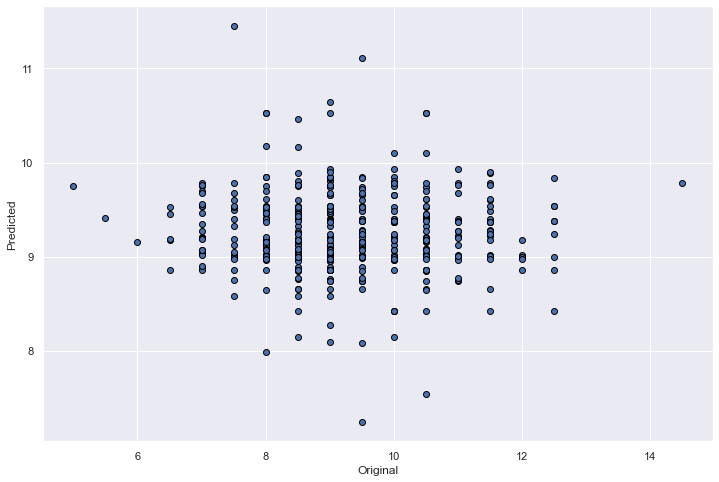

In [68]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(Y, predicted_y, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [70]:
r2=r2_score(Y, predicted_y)
mse=mean_squared_error(Y, predicted_y)
print(r2, mse)

-0.12766332059740226 2.0976576410643757
